In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Load des données

In [2]:
import numpy as np

# Chargement des fichiers
images = np.load('archive/sprites.npy', mmap_mode='r') 
labels = np.load('archive/sprites_labels.npy', mmap_mode='r')

# Inspection des données
print(f"Images Shape: {images.shape}") 
print(f"Images Dtype: {images.dtype}") 
print(f"Labels Shape: {labels.shape}")

Images Shape: (89400, 16, 16, 3)
Images Dtype: uint8
Labels Shape: (89400, 5)


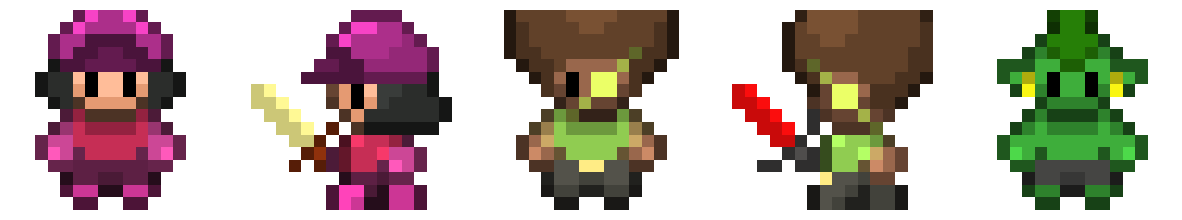

In [3]:
# Affichage de quelques images pour inspection
num_to_display = 5
plt.figure(figsize=(15, 3))
for i in range(num_to_display):
    plt.subplot(1, num_to_display, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
class SpriteDataset(Dataset):
    def __init__(self, img_path, label_path, transform=None):
        """
        Args:
            img_path (str): Chemin vers sprites.npy
            label_path (str): Chemin vers sprites_labels.npy
            transform (callable, optional): Transformations PyTorch.
        """
        self.images = np.load(img_path, mmap_mode='r')
        self.labels = np.load(label_path, mmap_mode='r')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Récupération de l'image et du label
        image = self.images[idx]
        label = self.labels[idx]

        # Transformation
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)


transform = transforms.Compose([
    transforms.ToTensor(), # Convertit (H, W, C) [0-255] -> (C, H, W) [0.0-1.0]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Convertit [0.0-1.0] -> [-1.0, 1.0] (on s'aligne avec la distribution du bruit gaussien)
])

dataset = SpriteDataset(
    img_path='archive/sprites.npy', 
    label_path='archive/sprites_labels.npy', 
    transform=transform
)

dataloader = DataLoader(
    dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=4,  
    pin_memory=True
)

# Test rapide d'un batch
imgs, lbls = next(iter(dataloader))
print(f"Batch shape: {imgs.shape}") # Devrait être [64, 3, H, W]
print(f"Value range: [{imgs.min():.2f}, {imgs.max():.2f}]") # Devrait être proche de [-1.00, 1.00]

# Bruitage

On utilise un Linear Schedule. Au début du processus de bruitage (t=0), on ajoute très peu de bruit (beta petit), alors qu'à la fin (t=1000), on en ajoute beaucoup plus.

L'astuce avec alpha : au lieu d'ajouter du bruit 1000 fois depuis une boucle pour avoir une image bruitée, on peut créer une image bruitée à n'importe quel niveau de dégradation, instantanément sans faire de boucle.

c:\Users\Cash\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\transforms\functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Forme de l'image x_0 : torch.Size([1, 3, 16, 16])
Plage de valeurs x_0 : [-1.00, 1.00]


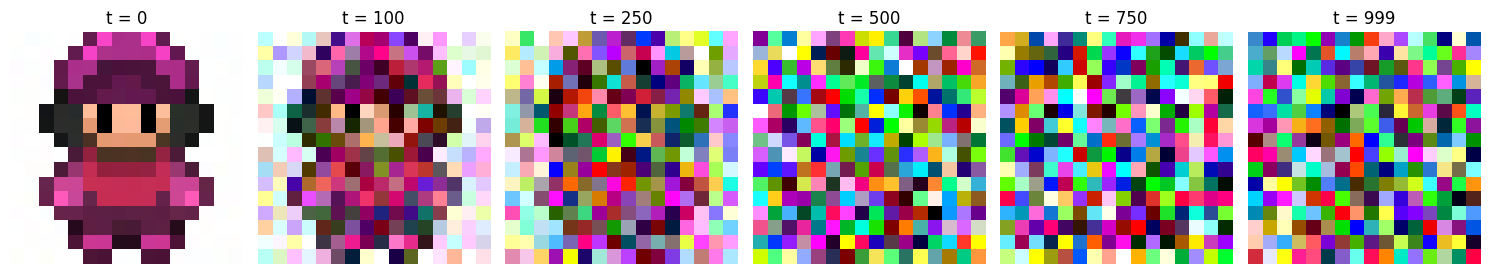

In [ ]:
# ==========================================
# 1. Configuration Mathématique du "Schedule"
# ==========================================
# Nombre total d'étapes de diffusion
# T : Le nombre d'étapes pour détruire complètement l'image.
T = 1000

# Betas (β) : La quantité de bruit ajoutée à chaque étape t.
# On utilise un schedule linéaire : peu de bruit au début, beaucoup à la fin.
betas = torch.linspace(0.0001, 0.02, T)

# Alphas (α = 1 - β) : La part de l'image originale que l'on garde à l'étape t.
alphas = 1. - betas

# Alphas Cumulés (ᾱ_t) : Produit de tous les alphas jusqu'à t.
alphas_cumprod = torch.cumprod(alphas, axis=0)

# --- Pré-calcul des coefficients pour la formule q(x_t | x_0) ---
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)

# Coefficient du bruit : sqrt(1 - ᾱ_t)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


# ==========================================
# 2. La Fonction de Diffusion Directe (Forward)
# ==========================================
def q_sample(x_0, t, noise=None):
    """
    Diffuse l'image x_0 jusqu'à l'étape t.
    x_0 : Tenseur [Batch, C, H, W] normalisé entre [-1, 1]
    t : Tenseur [Batch] contenant les indices de temps
    
    Mathématiquement : q(x_t | x_0) = N(x_t; sqrt(ᾱ_t)*x_0, (1-ᾱ_t)I)
    """

    # ε : Le bruit cible que le réseau devra prédire
    if noise is None:
        noise = torch.randn_like(x_0)

    # On récupère les coefficients constants pour le batch de temps t
    sqrt_alpha_bar_t = extract(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alpha_bar_t = extract(sqrt_one_minus_alphas_cumprod, t, x_0.shape)

    # Application de la formule Signal + Bruit (Reparameterization Trick)
    # x_t = (Signal * Image) + (Variance * Bruit)
    x_t = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise
    return x_t


# ==========================================
# 3. Chargement et Préparation d'une Image
# ==========================================
raw_images = np.load('archive/sprites.npy', mmap_mode='r')

example_img_np = raw_images[0]

# Transformation pour PyTorch :
# 1. ToTensor : Convertit numpy (H, W, C) [0-255] -> torch (C, H, W) [0.0-1.0]
# 2. Normalize : Convertit [0.0-1.0] -> [-1.0, 1.0] (Standard pour la diffusion)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Application de la transfo et ajout d'une dimension de batch [1, C, H, W]
x_0 = transform(example_img_np).unsqueeze(0)

print(f"Forme de l'image x_0 : {x_0.shape}")
print(f"Plage de valeurs x_0 : [{x_0.min():.2f}, {x_0.max():.2f}]")


# ==========================================
# 4. Visualisation du Bruitage
# ==========================================
def to_pil(tensor):
    tensor = (tensor.clamp(-1, 1) + 1) / 2
    tensor = tensor.permute(1, 2, 0) # CHW -> HWC pour matplotlib
    return tensor.numpy()

timesteps_to_visualize = [0, 100, 250, 500, 750, 999]

plt.figure(figsize=(15, 3))

for i, t_idx in enumerate(timesteps_to_visualize):
    t = torch.tensor([t_idx])

    x_t = q_sample(x_0, t)

    plt.subplot(1, len(timesteps_to_visualize), i + 1)
    plt.imshow(to_pil(x_t[0]))
    plt.title(f"t = {t_idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicUNet(nn.Module):
    """Architecture simplifiée pour valider la boucle d'entraînement"""
    def __init__(self, in_channels=3, time_emb_dim=32):
        super().__init__()
        # Encodage du temps (t)
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),
            nn.GELU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        # Traitement image
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, in_channels, 3, padding=1)

    def forward(self, x, t):
        # 1. Embedding du temps
        t = t.float().view(-1, 1) # [Batch, 1]
        t_emb = self.time_mlp(t)  # [Batch, 32]
        
        # Projection du temps sur les dimensions de l'image pour addition
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1) # [Batch, 32, 1, 1]
        
        # 2. Passage dans le réseau 
        x = F.gelu(self.conv1(x))
        return self.conv2(x) # La sortie doit avoir la même shape que l'entrée (le bruit)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SinusoidalPositionEmbeddings(nn.Module):
    """Encodage positionnel du temps t (comme dans les Transformers)"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
            
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (32, 64, 128, 256) 
        up_channels = (256, 128, 64, 32)
        out_dim = 3 
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) for i in range(len(down_channels)-1)])
        
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        
        residual_inputs = []
        for down in self.downs:
            residual_inputs.append(x)
            x = down(x, t)
            
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = up(x, t)
            
            # Sécurité dimensionnelle
            if x.shape != residual_x.shape:
                x = F.interpolate(x, size=residual_x.shape[2:])
                
            x = x + residual_x
            
        return self.output(x)

In [ ]:
import torch.optim as optim

# 1. Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 1e-4
EPOCHS = 100 
BATCH_SIZE = 64

sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(DEVICE)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(DEVICE)

# 2. Initialisation
model = SimpleUNet().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR)
loss_fn = nn.MSELoss() # Simple Mean Squared Error

print(f"Entraînement sur {DEVICE}...")

# 3. Training Loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for batch_idx, (x_0, labels) in enumerate(dataloader):
        x_0 = x_0.to(DEVICE)
        
        # --- A. Échantillonnage du Temps (Time Sampling) ---
        t = torch.randint(0, T, (x_0.shape[0],), device=DEVICE).long()
        
        # --- B. Création du Bruit (Ground Truth) ---
        epsilon = torch.randn_like(x_0).to(DEVICE)
        
        # --- C. Bruitage de l'image (Forward Process) ---
        sqrt_ab = extract(sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_ab = extract(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
        
        x_t = sqrt_ab * x_0 + sqrt_one_minus_ab * epsilon
        
        # --- D. Prédiction du Modèle ---
        noise_pred = model(x_t, t) # Si conditionnel: model(x_t, t, labels)
        
        # --- E. Calcul de la Loss et Backprop ---
        loss = loss_fn(noise_pred, epsilon)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Log par époque
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.5f}")


print("Entraînement terminé.")

Entraînement sur cpu...
Epoch 1/100 | Loss: 0.25664
Epoch 2/100 | Loss: 0.10745
Epoch 3/100 | Loss: 0.09255
Epoch 4/100 | Loss: 0.08346
Epoch 5/100 | Loss: 0.07850
Epoch 6/100 | Loss: 0.07515
Epoch 7/100 | Loss: 0.07191
Epoch 8/100 | Loss: 0.06966
Epoch 9/100 | Loss: 0.06724
Epoch 10/100 | Loss: 0.06575
Epoch 11/100 | Loss: 0.06338
Epoch 12/100 | Loss: 0.06332
Epoch 13/100 | Loss: 0.06156
Epoch 14/100 | Loss: 0.06090
Epoch 15/100 | Loss: 0.05950
Epoch 16/100 | Loss: 0.05863
Epoch 17/100 | Loss: 0.05766
Epoch 18/100 | Loss: 0.05723
Epoch 19/100 | Loss: 0.05615
Epoch 20/100 | Loss: 0.05552
Epoch 21/100 | Loss: 0.05514
Epoch 22/100 | Loss: 0.05468
Epoch 23/100 | Loss: 0.05393
Epoch 24/100 | Loss: 0.05307
Epoch 25/100 | Loss: 0.05258
Epoch 26/100 | Loss: 0.05241
Epoch 27/100 | Loss: 0.05165
Epoch 28/100 | Loss: 0.05198
Epoch 29/100 | Loss: 0.05072
Epoch 30/100 | Loss: 0.05078
Epoch 31/100 | Loss: 0.05019
Epoch 32/100 | Loss: 0.04977
Epoch 33/100 | Loss: 0.04926
Epoch 34/100 | Loss: 0.04881

In [27]:
# Save model
torch.save(model.state_dict(), "ddpm_sprites_final.pth")

Modèle chargé avec succès.
Début de la génération de 16 images...
Step 1900/2000
Step 1800/2000
Step 1700/2000
Step 1600/2000
Step 1500/2000
Step 1400/2000
Step 1300/2000
Step 1200/2000
Step 1100/2000
Step 1000/2000
Step 900/2000
Step 800/2000
Step 700/2000
Step 600/2000
Step 500/2000
Step 400/2000
Step 300/2000
Step 200/2000
Step 100/2000
Step 0/2000


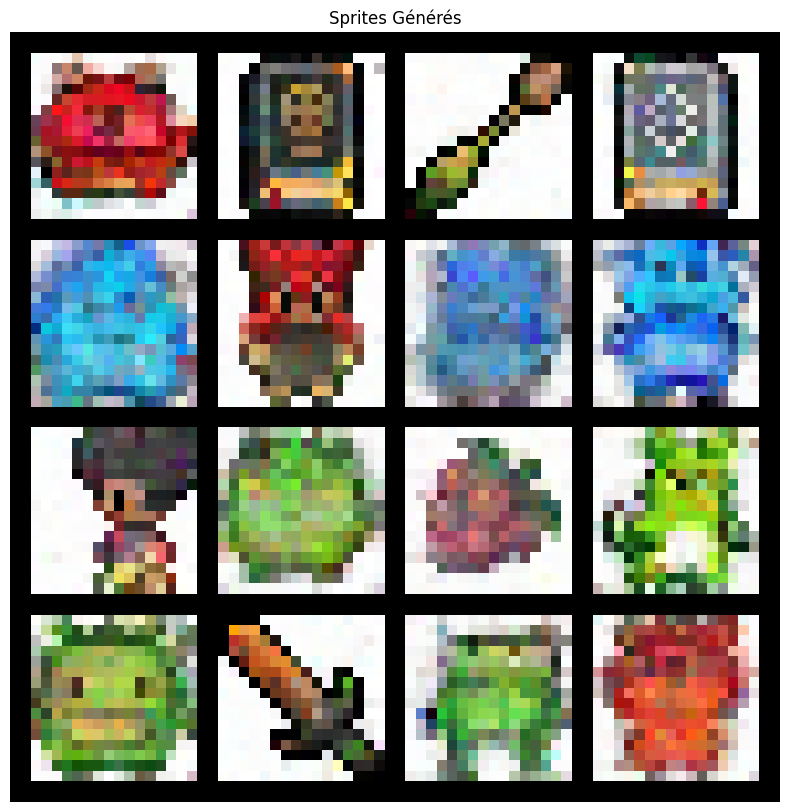

Image sauvegardée sous 'generated_sprites.png'


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# 1. Configuration & Constantes 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
T = 2000
IMG_SIZE = 16
CHANNELS = 3

# Recalcul du schedule (comme avant)
betas = torch.linspace(1e-4, 0.02, T).to(DEVICE)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# Fonction pour récupérer les valeurs au temps t
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

@torch.no_grad()
def sample_ddpm(model, n_samples):
    """
    Génère n_samples nouvelles images.
    Génère des images en partant du bruit pur et en le "nettoyant" itérativement.
    """
    model.eval()
    
    # A. On part d'un bruit gaussien pur (x_T)
    x = torch.randn((n_samples, CHANNELS, IMG_SIZE, IMG_SIZE)).to(DEVICE)
    
    print(f"Début de la génération de {n_samples} images...")
    
    # B. Boucle inverse : de T-1 à 0
    for i in reversed(range(0, T)):
        # Création du tenseur de temps pour le batch (tout le batch est au même t)
        t = torch.full((n_samples,), i, device=DEVICE, dtype=torch.long)
        
        # 1. Prédiction du bruit à retirer
        # Le modèle prédit le bruit présent dans l'image actuelle x_t
        predicted_noise = model(x, t)
        
        # 2. Calcul des coefficients pour ce timestep
        # Récupération des coefficients pour l'étape t
        betas_t = extract(betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(torch.sqrt(1. - alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
        
        # 3. Estimation de la moyenne (l'image un peu moins bruité)
        # FORMULE DE DÉBRUITAGE (Langevin Dynamics)
        # Formule : x_{t-1} = 1/sqrt(alpha) * (x_t - (beta / sqrt(1-alpha_bar)) * noise)
        model_mean = sqrt_recip_alphas_t * (
            x - (betas_t / sqrt_one_minus_alphas_cumprod_t) * predicted_noise
        )
        
        # 4. Ajout de la variance (Sauf pour la toute dernière étape t=0 où on veut le résultat net).
        if i > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(betas_t) 
            x = model_mean + sigma_t * noise
        else:
            x = model_mean
            
        # Barre de progression simple
        if i % 100 == 0:
            print(f"Step {i}/{T}")

    # C. Post-traitement : [-1, 1] -> [0, 1] pour l'affichage
    x = (x.clamp(-1, 1) + 1) / 2
    return x

# --- Exécution ---

if __name__ == "__main__":
    # 1. Charger l'architecture
    model = SimpleUNet().to(DEVICE)
    
    # 2. Charger les poids entraînés
    try:
        model.load_state_dict(torch.load("ddpm_sprites_final.pth", map_location=DEVICE))
        print("Modèle chargé avec succès.")
    except FileNotFoundError:
        print("Erreur : Fichier de poids non trouvé. Vérifiez le chemin.")
        exit()

    # 3. Générer
    generated_images = sample_ddpm(model, n_samples=16)

    # 4. Affichage
    plt.figure(figsize=(10, 10))
    # Création d'une grille 4x4
    grid = make_grid(generated_images, nrow=4, padding=2)
    # Permute pour Matplotlib (C, H, W) -> (H, W, C)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title("Sprites Générés")
    plt.show()
    
    # Sauvegarde
    from torchvision.utils import save_image
    save_image(generated_images, "generated_sprites.png")
    print("Image sauvegardée sous 'generated_sprites.png'")